# Ouija pseudotime using Edward and Tensorflow

In [121]:
%pylab inline

import tensorflow as tf
import edward as ed
import pandas as pd
import feather
import six

from edward.models import Normal, Gamma, Beta, Categorical, Mixture, ParamMixture

from edward.util import get_session, get_variables

ds = tf.contrib.distributions

%run logit_shift_bijector

Populating the interactive namespace from numpy and matplotlib


## Data input

In [122]:
exprs = feather.read_dataframe("data/expression.feather")
pdata = feather.read_dataframe("data/cycledat.feather")

In [123]:
pdata.head()

,Progression.Rank,Estimated.phase,cellid,population,pc1
0,1059,G1(late),4,young LT-HSC,-5.274233
1,1139,G1(late),5,young LT-HSC,-7.434146
2,1105,G1(late),6,young LT-HSC,-8.756307
3,945,G1(early),10,young LT-HSC,-8.967951
4,1242,S,11,young LT-HSC,23.389776


In [124]:
exprs_mat = exprs.as_matrix().T
N = exprs_mat.shape[0]
G = exprs_mat.shape[1]
Q = 1

## Build model

In [125]:
k = Normal(loc = tf.zeros([G,Q]), scale = 50 * tf.ones([G,Q]), name = "k")
t0 = Normal(loc = 0.5 * tf.ones(G), scale = 1 * tf.ones(G)) # Beta(1.5 * tf.ones(G), 1.5 * tf.ones(G)) # 
mu0 = Gamma(concentration = 2 * tf.ones(G), rate = tf.ones(G))

z = Normal(loc = 0.5 * tf.ones([N,Q]), scale = tf.ones([N,Q]))

phi = Gamma(concentration = 2 * tf.ones(1), rate = tf.ones(1))

In [126]:
pbeta = Normal(loc = tf.zeros(2), scale = tf.ones(2))

In [127]:
cell_mat = tf.stack([tf.reshape(z, [-1]), -tf.ones(N)], 1)
gene_mat = tf.stack([tf.reshape(k, [-1]), tf.reshape(k, [-1]) * tf.reshape(t0, [-1])], 1)

In [128]:
gene_mat

<tf.Tensor 'stack_11:0' shape=(374, 2) dtype=float32>

In [129]:
factor_mult = tf.matmul(cell_mat, gene_mat, transpose_b = True) 
mu = mu0 * tf.nn.sigmoid(factor_mult)

In [130]:
prob_dropout = pbeta[0] + pbeta[1] * mu

In [131]:
%run dropout_normal
Y = DropoutNormal(p_dropout = prob_dropout, loc = mu, scale = tf.sqrt(1 + phi * mu))
Y._p_dropout = prob_dropout

In [132]:
%run logit_shift_bijector.py
qk = Normal(loc = tf.Variable(tf.zeros([G, Q])),
           scale = tf.nn.softplus(tf.Variable(tf.zeros([G, Q]))))

qz = ed.models.TransformedDistribution(
    distribution = ed.models.NormalWithSoftplusScale(loc = tf.Variable(tf.zeros([N,Q])),
                                                    scale = tf.Variable(tf.ones([N,Q]))),
    bijector = LogitShiftBijector(a = tf.zeros([N,Q]), b = tf.ones([N,Q])),
    name = "qz"
)

qmu0 = ed.models.TransformedDistribution(
    distribution = ed.models.NormalWithSoftplusScale(loc = tf.Variable(tf.zeros(G)),
                                                    scale = tf.Variable(tf.ones(G))),
    bijector = ds.bijectors.Exp(),
    name = "qmu0"
)

qphi = ed.models.TransformedDistribution(
    distribution = ed.models.NormalWithSoftplusScale(loc = tf.Variable(tf.zeros(1)),
                                                    scale = tf.Variable(tf.ones(1))),
    bijector = ds.bijectors.Exp(),
    name = "qphi"
)

qt0 = ed.models.TransformedDistribution(
    distribution = ed.models.NormalWithSoftplusScale(loc = tf.Variable(tf.zeros(G)),
                                                    scale = tf.Variable(tf.ones(G))),
    bijector = LogitShiftBijector(a = tf.zeros(G), b = tf.ones(G)),
    name = "qt0"
)

qbeta = Normal(loc = tf.Variable(tf.zeros(2)),
           scale = tf.nn.softplus(tf.Variable(tf.ones(2))))

In [133]:
approx_dict = {
    k: qk,
    z: qz,
    mu0: qmu0,
    phi: qphi,
    t0: qt0,
    pbeta: qbeta
}

data_dict = {Y: exprs_mat}

In [134]:
inference = ed.KLqp(approx_dict, data = data_dict)
inference.run(n_iter = 3000, logdir = 'log')
inference.finalize()

3000/3000 [100%] ██████████████████████████████ Elapsed: 94s | Loss: 131520.594


In [135]:
qbeta.parameters['loc'].eval()

array([ 3.33795691, -7.72962523], dtype=float32)

In [136]:
qphi.bijector.forward(qphi.distribution.loc).eval()

array([ 0.00071902], dtype=float32)

In [137]:
    zmap = qz.bijector.forward(qz.distribution.parameters['loc']).eval()

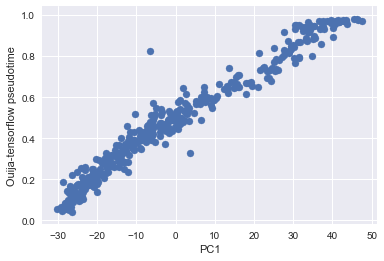

In [138]:
plt.scatter(pdata.pc1, zmap)
plt.xlabel("PC1")
plt.ylabel("Ouija-tensorflow pseudotime")

## Save results

Per-cell data

In [139]:
qz_sd = tf.nn.softplus(qz.distribution.parameters['scale'])

In [140]:
cell_df = pd.DataFrame({
        "z_mean": qz.bijector.forward(qz.distribution.parameters['loc']).eval().reshape(-1),
       "z_lower": qz.bijector.forward(qz.distribution.parameters['loc'] - qz_sd ).eval().reshape(-1),
       "z_upper": qz.bijector.forward(qz.distribution.parameters['loc'] + qz_sd).eval().reshape(-1)
    })

Per-gene data

In [141]:
t0_sd = tf.nn.softplus(qt0.distribution.parameters['scale'])
k_sd = tf.nn.softplus(qk.parameters['scale'])

k_mean = qk.parameters['loc']
t0_mean = qt0.distribution.parameters['loc']

mu0_mean = qmu0.bijector.forward(qmu0.distribution.parameters['loc'])

In [142]:
k_mean.eval().reshape(-1)[0:5] == qk.loc.eval().reshape(-1)[0:5]

array([ True,  True,  True,  True,  True], dtype=bool)

In [143]:
gene_df = pd.DataFrame({
        "k_mean": k_mean.eval().reshape(-1),
        "k_lower": (k_mean - k_sd).eval().reshape(-1),
        "k_upper": (k_mean + k_sd).eval().reshape(-1),
        "t0_mean": qt0.bijector.forward(t0_mean).eval().reshape(-1),
        "t0_lower": qt0.bijector.forward(t0_mean - t0_sd).eval().reshape(-1),
        "t0_upper": qt0.bijector.forward(t0_mean + t0_sd).eval().reshape(-1),
        "mu0_mean": mu0_mean.eval().reshape(-1)
    })

In [144]:
gene_df.head()

,k_lower,k_mean,k_upper,mu0_mean,t0_lower,t0_mean,t0_upper
0,-0.825867,-0.004695,0.816476,1.859116,0.291767,0.467786,0.652206
1,0.014189,0.932918,1.851648,0.633066,0.401502,0.489594,0.578337
2,-0.564022,0.242427,1.048877,2.075061,0.623703,0.707391,0.779060
3,7.747986,9.774510,11.801035,0.736306,0.490198,0.512365,0.534483
4,-6.353398,-2.552651,1.248096,0.231942,0.297090,0.497533,0.698771


In [145]:
feather.write_dataframe(cell_df, "data/cell_df.feather")
feather.write_dataframe(gene_df, "data/gene_df.feather")

In [38]:
%pwd

'/Users/kieranc/oxford/bnlfa/ouijaflow'